## NOTES:
<ul>
<li>This notebook allows for further analysis of a single site and single metric from the dataset produced by aquifer analysis</li>
<li>The purpose is primarily for data visualization as well as deeper exploration into sites of interest. It is also for data validation. Additionally, this notebook gives more insight into what each metric is measuring and what each column of the aquifer analysis data sets represent</li><br>
<li>Each metric can be run independently of any others and are calculated using the same methods as in the aquifer analysis</li>
<li>As such, each metric is calculated independently here rather than relying on any data from any previous cells to ensure reliability</li>
<li>Furthermore, each visual is produced using the raw data, rather than the results of the calculations so that conclusions can be drawn on whether or not the visualization matches with the calculations</li>
</ul>

## CORE: Imports and Controls

In [1]:
# Imports -- Python 3.10
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import ticker
from importlib import reload
from dataretrieval import nwis
from datetime import timedelta

# Custom libs
import Src.func as fn
import Src.classes as cl
reload(fn)
reload(cl)

pd.options.mode.chained_assignment = None

c:\Users\alekh\AppData\Local\Programs\Python\Python310\lib\site-packages\dataretrieval\nadp.py:44: UserWarning: GDAL not installed. Some functions will not work.
  warnings.warn('GDAL not installed. Some functions will not work.')


In [2]:
# Controls
# '11447650' -- SRB
site_no = '03592000'

K_DEFAULT_START = '1900-10-01'
K_DEFAULT_END = '2014-09-30' # end date for Kocis paper

DEFAULT_START = '1900-10-01'
DEFAULT_END = '2020-09-30' # end date for this study
df = nwis.get_record(sites=site_no, service=fn.SERVICE, parameterCD=fn.PARAM_CODE, start=DEFAULT_START, end=DEFAULT_END)

# Aquifer analysis is done on both 30 and 50-year periods with both 90 and 95% quantiles
data_range = 30 
quantile = 0.90

## METRIC: Valid
The `valid` column indicates whether a given site is missing no more than `MAX_MISSING_THRESHOLD` percent of its data across the analyzed range. For the purposes of this study `MAX_MISSING_THRESHOLD` is set to 10%.

Valid: True -- Missing 6.6350%


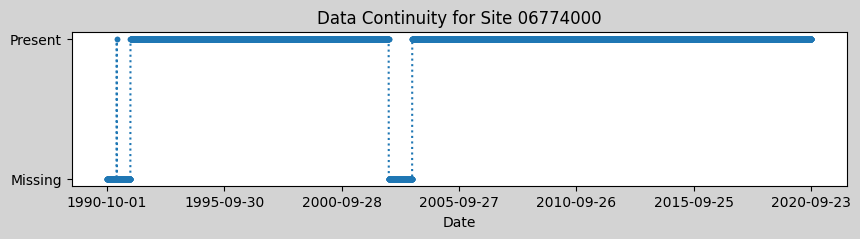

In [3]:
df_valid = df.reset_index()

# Trim the dataset to just the current analyzed date range (end date - data_range)
# Set all present values to 1
start = pd.to_datetime(DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_valid = df_valid[df_valid['datetime'].dt.date >= start]
df_valid['00060_Mean'] = 1 

# Validation using the predetermined start and end dates of (1970/90-2020)
missing = fn.validate(df_valid, start, DEFAULT_END)
print(f"Valid: {missing < fn.MAX_MISSING_THRESHOLD} -- Missing {missing * 100:.4f}%")

# Create missing dates and set their values to 0
complete_range = pd.date_range(start=start, end=DEFAULT_END, freq='D')
df_complete = pd.DataFrame({'datetime': complete_range})
df_valid = pd.concat([df_complete.set_index('datetime').tz_localize(None), df_valid.set_index('datetime').tz_localize(None)], axis=1, join='outer').fillna(0).reset_index()

plt.figure(figsize=(10, 2), facecolor='lightgray')
plt.plot(df_valid['datetime'], df_valid['00060_Mean'], marker='.', linestyle='dotted')

plt.yticks([0, 1], ['Missing', 'Present'])
plt.xticks(df_valid['datetime'][::(365*5)])
plt.xlabel("Date")

plt.title(f"Data Continuity for Site {site_no}")
plt.show()

## METRIC: Threshold
The `threshold` value is the flow value (ft<sup>3</sup>/s) above which any excess flow is considered high magnitude flow (HMF). This value is calculated as some quantile, 90% and 95% in the case of this study, of the total streamflow.

Threshold: 281.0


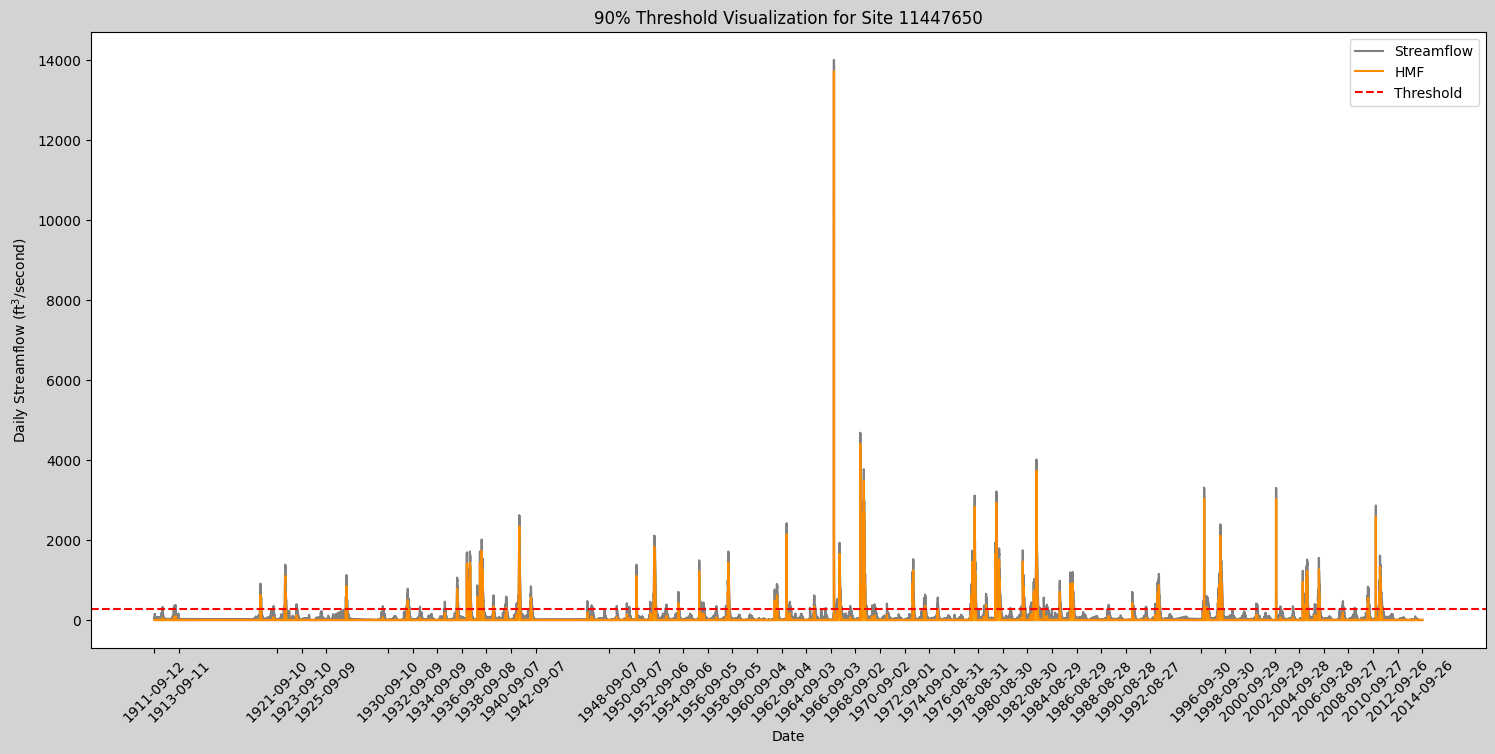

In [11]:
df_threshold = df.reset_index()

#start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
#df_threshold = df_threshold[df_threshold['datetime'].dt.date >= start]


threshold = fn.calc_threshold(df_threshold, quantile)
print(f"Threshold: {threshold}")

df_threshold["diff"] = df_threshold["00060_Mean"] - threshold
df_threshold["hmf"] = df_threshold["diff"].apply(lambda x: max(0, x))

'''window = 50
df_threshold["00060_Mean"] = df_threshold["00060_Mean"].rolling(window=window).mean()
df_threshold["hmf"] = df_threshold["hmf"].rolling(window=window).mean()'''

plt.figure(figsize=(18, 8), facecolor='lightgray')
plt.plot(df_threshold["datetime"], df_threshold["00060_Mean"], label="Streamflow", color="gray")
plt.plot(df_threshold["datetime"], df_threshold["hmf"], label="HMF", color="darkorange")
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

plt.fill_between(df_threshold["datetime"], df_threshold["00060_Mean"], color="gray")
plt.fill_between(df_threshold["datetime"], df_threshold["hmf"], color="orange")

plt.xticks(df_threshold['datetime'][::(365*2)], rotation=45)
plt.xlabel("Date")

plt.ylabel('Daily Streamflow ($\mathregular{ft^3}$/second)')

plt.title(f"{quantile*100:.0f}% Threshold Visualization for Site {site_no}")
plt.legend()
plt.show()

## METRIC: HMF Years, Inter-Annual Frequency
The `hmf_years` column tracks the total number of hydrologic years over the analyzed range that saw any amount of HMF. `inter_annual` tracks the frequency with which years experience at least one HMF event.

HMF Years: 19
Inter-Annual: 0.7601040525739321
Delta 25, 24.996577686516083
Min: 1990 Max: 2015


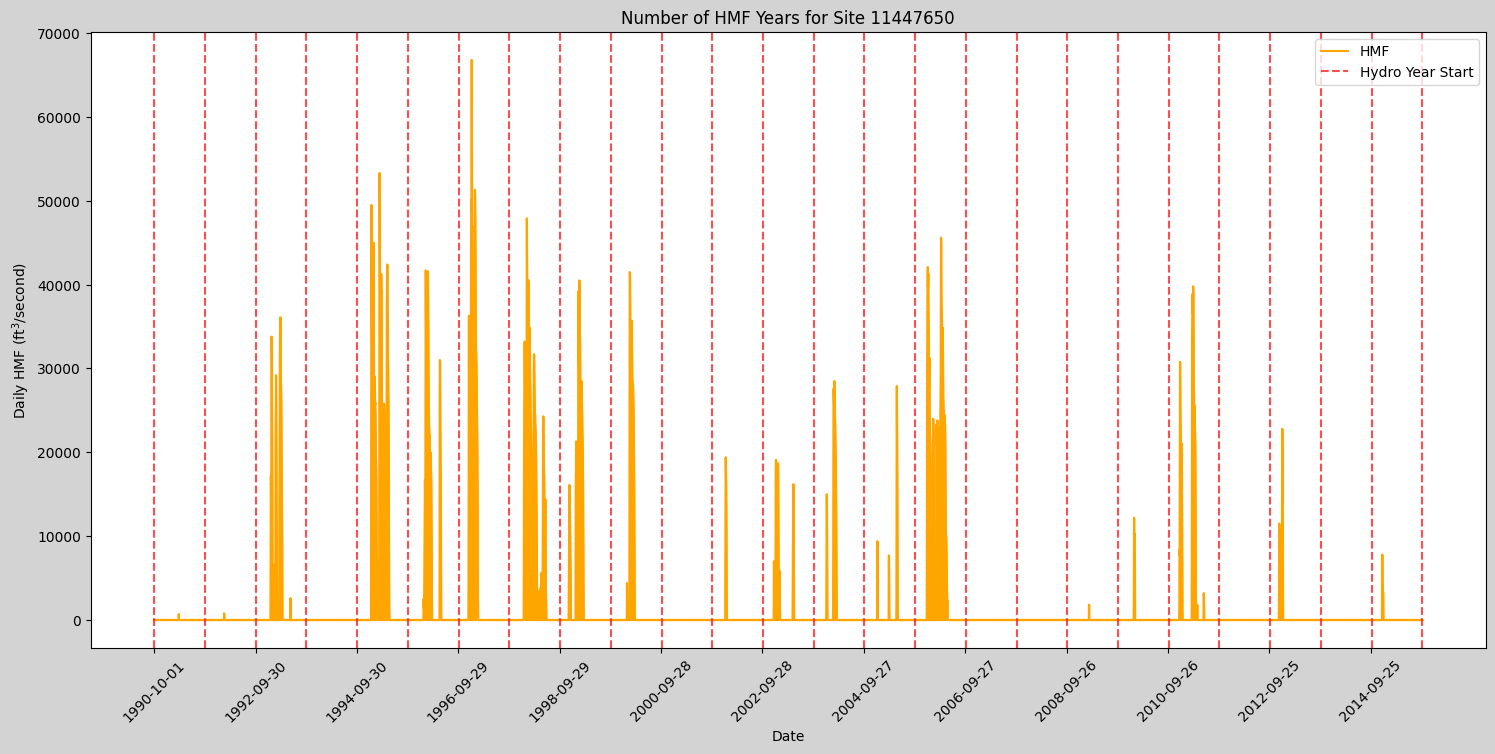

In [9]:
df_threshold = df.reset_index()

start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_threshold = df_threshold[df_threshold['datetime'].dt.date >= start]

threshold = fn.calc_threshold(df_threshold, quantile)
hmf_series_defl, hmf_series_cont = fn.filter_hmf(df_threshold, threshold)
hmf_years = fn.num_hmf_years(hmf_series_defl)
print(f"HMF Years: {hmf_years}")
delta = (hmf_series_cont["datetime"].max() - hmf_series_cont["datetime"].min()).days / 365.25
print(f"Inter-Annual: {hmf_years / delta}")
print(f'Delta {math.ceil(delta)}, {delta}')
print(f'Min: {hmf_series_cont["datetime"].min().year} Max: {hmf_series_cont["datetime"].max().year}')

df_threshold["diff"] = df_threshold["00060_Mean"] - threshold
df_threshold["hmf"] = df_threshold["diff"].apply(lambda x: max(0, x))

plt.figure(figsize=(18, 8), facecolor='lightgray')
plt.plot(df_threshold["datetime"], df_threshold["hmf"], label="HMF", color="orange")

first = True
for year in range(df_threshold["datetime"].dt.year.min(), df_threshold["datetime"].dt.year.max() + 1):
    oct1 = pd.to_datetime(f'{year}-10-01')

    if first:
        plt.axvline(oct1, color='red', linestyle='--', alpha=0.7, label='Hydro Year Start')
        first = False
    else:
        plt.axvline(oct1, color='red', linestyle='--', alpha=0.7)        

plt.fill_between(df_threshold["datetime"], df_threshold["hmf"], color="orange")

plt.xticks(df_threshold['datetime'][::(365*2)], rotation=45)
plt.xlabel("Date")

plt.ylabel('Daily HMF ($\mathregular{ft^3}$/second)')

plt.title(f"Number of HMF Years for Site {site_no}")
plt.legend()
plt.show()



## METRIC: Annual HMF
The `annual_hmf` column holds the average amount of HMF, in km<sup>3</sup> per year.

Annual HMF: 2.11 km^3/year


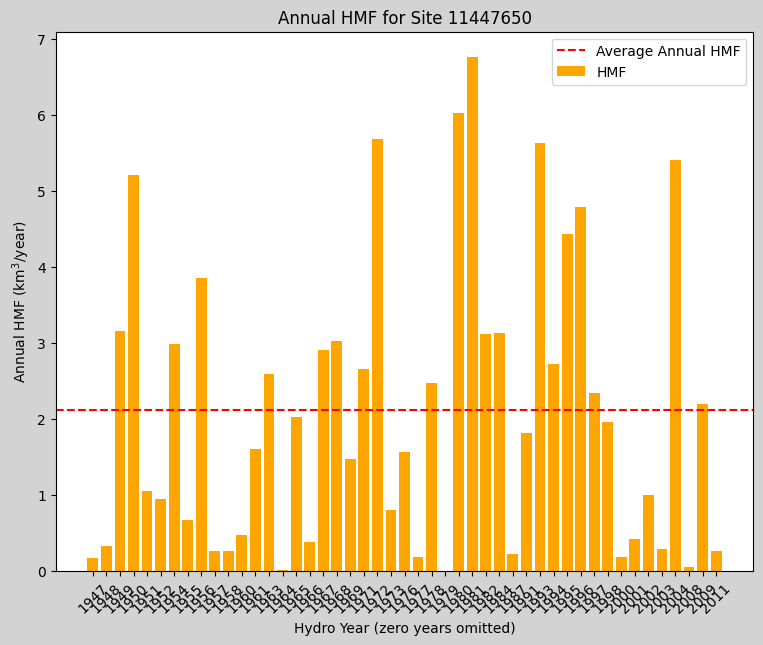

In [51]:
df_annualhmf = df.reset_index()

#start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
#df_annualhmf = df_annualhmf[df_annualhmf['datetime'].dt.date >= start]

threshold = fn.calc_threshold(df_annualhmf, quantile)
hmf_series, _ = fn.filter_hmf(df_annualhmf, threshold)
hmf_years = fn.num_hmf_years(hmf_series)
hmf_series = fn.convert_hmf(hmf_series, threshold)

hmf_series = hmf_series.reset_index()
hmf_series['datetime'] = pd.to_datetime(hmf_series['datetime'])
hmf_series.set_index('datetime', inplace=True)

annual_sum = hmf_series['00060_Mean'].resample(fn.HYDRO_YEAR).sum()
annual_sum = annual_sum * fn.CUBIC_FT_KM_FACTOR
annual_hmf = annual_sum.sum() / hmf_years
print(f"Annual HMF: {annual_hmf:.2f} km^3/year")

# Filtering out 0 years since average is calculated using only non-zero years
# and this will make the visualization more accurate
annual_sum = annual_sum[annual_sum > 0]

fig = plt.figure(figsize=(9, 7), facecolor='lightgray')
plt.bar(range(len(annual_sum.index)), annual_sum, color='orange')
plt.axhline(y=annual_hmf, color='r', linestyle='--')

plt.xlabel('Hydro Year (zero years omitted)')
plt.xticks(range(len(annual_sum.index)), annual_sum.index.strftime('%Y'), rotation=45)
plt.ylabel('Annual HMF ($\mathregular{km^3}$/year)')

plt.title(f'Annual HMF for Site {site_no}')
plt.legend(['Average Annual HMF', 'HMF'])
plt.show()


## METRIC: 3 and 6 Month HMF
The `three_mo_hmf` and `six_mo_hmf` columns indicate the HMF (in km<sup>3</sup>/year) over a selected 3-month and 6-month window of the wettest months of the hydrologic year. The default 3-month window is from Dec-Feb, while the 6-month window is Nov-Apr.

In [41]:
# Window selection by month
three_start = 12
three_end = 2
six_start = 11
six_end = 4

# Window to view for first plot (visualization is too busy with windows larger than one year)
window_start = pd.Timestamp('1994-10-01')
window_end = pd.Timestamp(window_start + pd.DateOffset(days=365))

In [ ]:
df_threesix = df.reset_index()

start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_threesix = df_threesix[df_threesix['datetime'].dt.date >= start]

threshold = fn.calc_threshold(df_threesix, quantile)
hmf_series, _ = fn.filter_hmf(df_threesix, threshold)
hmf_years = fn.num_hmf_years(hmf_series)

df_six_mo, df_three_mo = fn.three_six_range(hmf_series, three_start, three_end, six_start, six_end)

# For final report 
hmf_series = fn.convert_hmf(hmf_series, threshold)
hmf_series = hmf_series.reset_index(drop=True)
total_hmf_flow = (hmf_series["00060_Mean"].sum() * fn.CUBIC_FT_KM_FACTOR) / hmf_years

df_six_mo = fn.convert_hmf(df_six_mo, threshold)
df_six_mo = df_six_mo.reset_index(drop=True)
six_mo_hmf = (df_six_mo["00060_Mean"].sum() * fn.CUBIC_FT_KM_FACTOR) / hmf_years

df_three_mo = fn.convert_hmf(df_three_mo, threshold)
df_three_mo = df_three_mo.reset_index(drop=True) 
three_mo_hmf = (df_three_mo["00060_Mean"].sum() * fn.CUBIC_FT_KM_FACTOR) / hmf_years  

# Calculate the percentage of each HMF value compared to the total HMF flow
total_hmf_percentage = total_hmf_flow / total_hmf_flow * 100
six_mo_hmf_percentage = six_mo_hmf / total_hmf_flow * 100
three_mo_hmf_percentage = three_mo_hmf / total_hmf_flow * 100

print(f"6 Month HMF: {six_mo_hmf:.2f} -- {six_mo_hmf_percentage:.2f}% of Total HMF")
print(f"3 Month HMF: {three_mo_hmf:.2f} -- {three_mo_hmf_percentage:.2f}% of Total HMF")

# The following is all for plotting purposes and does not occur in Aquifer Analysis
# Fill missing datetime values with 0's for plotting
df_six_mo.drop(columns=['index'], inplace=True)
df_three_mo.drop(columns=['index'], inplace=True)
df_six_mo = df_six_mo.set_index('datetime').resample('D').asfreq().fillna(0).reset_index()
df_three_mo = df_three_mo.set_index('datetime').resample('D').asfreq().fillna(0).reset_index()

# Zero out any negative HMF values (days where streamflow is below threshold)
df_threesix["diff"] = df_threesix["00060_Mean"] - threshold
df_threesix["hmf"] = df_threesix["diff"].apply(lambda x: max(0, x))
df_six_mo["diff"] = df_six_mo["00060_Mean"] - threshold
df_six_mo["hmf"] = df_six_mo["diff"].apply(lambda x: max(0, x))
df_three_mo["diff"] = df_three_mo["00060_Mean"] - threshold
df_three_mo["hmf"] = df_three_mo["diff"].apply(lambda x: max(0, x))

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True, facecolor='lightgray')

# Plot for total hmf
axes[0].plot(df_threesix["datetime"], df_threesix["hmf"], label="df_threesix", color="orange")
axes[0].fill_between(df_threesix["datetime"], df_threesix["hmf"], color="orange")
axes[0].set_ylabel('Daily HMF ($\mathregular{ft^3}$/second)')
axes[0].set_title(f'HMF for Site {site_no} During {window_start.year} Hydrological Year')
axes[0].set_xlim(window_start, window_end) 

# Plot for six month hmf
axes[1].plot(df_six_mo["datetime"], df_six_mo["hmf"], label="df_six_mo", color="lightcoral")
axes[1].fill_between(df_six_mo["datetime"], df_six_mo["hmf"], color="lightcoral")
axes[1].set_ylabel('Daily HMF ($\mathregular{ft^3}$/second)')
axes[1].set_title('Six Month HMF')
axes[0].set_xlim(window_start, window_end) 

# Plot for three month hmf
axes[2].plot(df_three_mo["datetime"], df_three_mo["hmf"], label="df_three_mo", color="orchid")
axes[2].fill_between(df_three_mo["datetime"], df_three_mo["hmf"], color="orchid")
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Daily HMF ($\mathregular{ft^3}$/second)')
axes[2].set_title('Three Month HMF')
axes[0].set_xlim(window_start, window_end) 

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6), facecolor='lightgray')
plt.bar(['Total HMF', 'Six Month HMF', 'Three Month HMF'], [total_hmf_flow, six_mo_hmf, three_mo_hmf], color=['orange', 'lightcoral', 'orchid'])

plt.axhline(y=six_mo_hmf, color='r', linestyle='--')
plt.axhline(y=three_mo_hmf, color='r', linestyle='--')

for i, v in enumerate([total_hmf_flow, six_mo_hmf, three_mo_hmf]):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.title(f'HMF Comparison for Site {site_no} Across Full Range')
plt.ylabel('Average Annual HMF ($\mathregular{km^3}$/year)')

plt.text(0, total_hmf_flow - 0.5, f'{total_hmf_percentage:.2f}%', ha='center')
plt.text(1, six_mo_hmf - 0.5, f'{six_mo_hmf_percentage:.2f}%', ha='center')
plt.text(2, three_mo_hmf - 0.5, f'{three_mo_hmf_percentage:.2f}%', ha='center')

plt.show()


## METRICS: Annual/Event Durations, Event HMF, and Intra-annual Frequency
The `average_duration` column measures the average number of days per HMF event per hydrologic year while the `event_duration` column reports the average number of days per HMF event. `event_hmf` is the average amount of HMF per event while the `intra-annual` column is the average number of events per year

In [4]:
df_duration = df.reset_index()
df_results = pd.DataFrame()

start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_duration = df_duration[df_duration['datetime'].dt.date >= start]
threshold = fn.calc_threshold(df_duration, quantile)
hmf_series_defl, hmf_series_cont = fn.filter_hmf(df_duration, threshold)
hmf_series_cont = fn.convert_hmf(hmf_series_cont, threshold)
hmf_years = fn.num_hmf_years(hmf_series_defl)

df_d = hmf_series_cont.reset_index()
df_d['datetime'] = df_d['datetime'] + pd.DateOffset(months=-9)
df_d['flow_bool'] = df_d['00060_Mean'].apply(lambda x: 1 if x > 0 else 0)

# Average HMF/year calculation
df_results = df_d.groupby(df_d["datetime"].dt.year)["00060_Mean"].sum().reset_index()
df_results["00060_Mean"] = df_results["00060_Mean"] * fn.CUBIC_FT_KM_FACTOR

# Total days per year calculation
df_results["total_days"] = df_d.groupby(df_d["datetime"].dt.year)["flow_bool"].sum().reset_index()["flow_bool"]

# Total events per year calculation
# Insert a day at the very beginning of the dataframe with flow_bool == 0 so that the first event is counted via diff()
first = df_d['datetime'].iloc[0] - timedelta(days=1)
insert = {'datetime': first, '00060_Mean': 0,  '00060_Mean_cd': None, 'site_no': None, 'flow_bool': 0}
df_d = pd.concat([pd.DataFrame(insert, index=[0]), df_d]).reset_index(drop=True)

df_d['Year'] = df_d['datetime'].dt.year
df_d['Change'] = df_d['flow_bool'].diff()

# Set Change == 1 if the first day of the year has an event to account for events spanning the new year
year_start_mask = (df_d['datetime'].dt.month == 1) & (df_d['datetime'].dt.day == 1)
df_d.loc[year_start_mask & (df_d['flow_bool'] == 1), 'Change'] = 1

series_continuous_sets = df_d[(df_d['Change'] == 1) & (df_d['flow_bool'] == 1)].groupby('Year').size()
series_continuous_sets = series_continuous_sets.reset_index()
series_continuous_sets.columns = ['Year', 'total_events']
df_results.rename(columns={'datetime': 'Year'}, inplace=True)
df_results = pd.merge(df_results, series_continuous_sets, on='Year', how='left')
df_results = df_results.fillna(0)

# Event HMF
df_results['event_hmf'] = df_results['00060_Mean'] / df_results['total_events']

# Event Duration
df_results['duration'] = df_results['total_days'] / df_results['total_events']

df_results = df_results.fillna(0)
annual_duration = df_results['total_days'].sum() / hmf_years    
event_duration = df_results['duration'].sum() / hmf_years
intra_annual = df_results['total_events'].sum() / hmf_years
event_hmf = df_results['event_hmf'].sum() / hmf_years

print(f'Annual Duration: {annual_duration:.2f} days')
print(f"Event Duration: {event_duration:.2f} days")
print(f"Intra-Annual: {intra_annual:.2f} events")
print(f'Event HMF: {event_hmf:.5f} km^3/year')
print(df_results)
#df_results.to_csv('event_duration.csv')

Annual Duration: 37.67 days
Event Duration: 10.43 days
Intra-Annual: 3.37 events
Event HMF: 0.00681 km^3/year
    Year  00060_Mean  total_days  total_events  event_hmf   duration
0   1990    0.009637           2           1.0   0.009637   2.000000
1   1991    0.019380          87           7.0   0.002769  12.428571
2   1992    0.194187         128           2.0   0.097094  64.000000
3   1993    0.000734          94           3.0   0.000245  31.333333
4   1994    0.076328         128           5.0   0.015266  25.600000
5   1995    0.000130           2           2.0   0.000065   1.000000
6   1996    0.005238          14           2.0   0.002619   7.000000
7   1997    0.014024         101           6.0   0.002337  16.833333
8   1998    0.004507          28           5.0   0.000901   5.600000
9   1999    0.003100           4           2.0   0.001550   2.000000
10  2000    0.010490          22           2.0   0.005245  11.000000
11  2001    0.002892           6           1.0   0.002892   6.

## METRIC: Timing
The `timing` column reports the average day in the hydrologic year that HMF reaches the halfway point of it's annual amount (the center of mass)

In [6]:
df_timing = df.reset_index()
start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_timing = df_timing[df_timing['datetime'].dt.date >= start]

threshold = fn.calc_threshold(df_timing, quantile)
hmf_series_defl, _ = fn.filter_hmf(df_timing, threshold)
hmf_series_defl = fn.convert_hmf(hmf_series_defl, threshold)

print(hmf_series_defl)

df_t = hmf_series_defl.reset_index(drop=True)
df_t['datetime'] = df_t['datetime'] + pd.DateOffset(months=-9)

df_t['year'] = df_t['datetime'].dt.year
df_t['day'] = df_t['datetime'].dt.dayofyear
df_t['cumsum'] = df_t.groupby('year')['00060_Mean'].cumsum()
df_t['t_sum'] = df_t.groupby('year')['00060_Mean'].transform('sum')

com_series = df_t[df_t['cumsum'] >= df_t['t_sum'] / 2].groupby('year')['day'].first()
print(f'Timing: {com_series.mean()}')
print(com_series)


                       datetime   00060_Mean 00060_Mean_cd   site_no
15517 1991-03-27 00:00:00+00:00   60480000.0             A  11447650
15843 1992-02-16 00:00:00+00:00   69120000.0             A  11447650
15844 1992-02-17 00:00:00+00:00   51840000.0             A  11447650
16177 1993-01-15 00:00:00+00:00   43200000.0             A  11447650
16178 1993-01-16 00:00:00+00:00  475200000.0             A  11447650
...                         ...          ...           ...       ...
24185 2014-12-19 00:00:00+00:00  336960000.0             A  11447650
24186 2014-12-20 00:00:00+00:00  354240000.0             A  11447650
24187 2014-12-21 00:00:00+00:00  293760000.0             A  11447650
24188 2014-12-22 00:00:00+00:00  293760000.0             A  11447650
24189 2014-12-23 00:00:00+00:00  259200000.0             A  11447650

[913 rows x 4 columns]
Timing: 142.26315789473685
year
1990    178
1991    136
1992    172
1994    169
1995    145
1996    103
1997    146
1998    139
1999    149
2001    